# TCC

- Problema: localização de minérios
- Solução: aplicação de aprendizado de máquina com uso de dados de espectrometria e gravimetria para classificar locais com alta probabilidade de conter minérios

---
- Processamento:
  - Problemas: 
    - conversão de coordenadas para latitude/longitude e uso de 3 casas decimais para evitar perda de dados durante mesclagem de dados


---

Ref Github: https://github.com/lszam/mineralexp

In [ ]:
import os
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, classification_report
import shap

filterwarnings("ignore")

In [2]:
dir_projeto = Path(os.getcwd()).parent.absolute()
data_dir = Path(dir_projeto, "Output", "tcc")
shp_dir = Path(data_dir, "shp")

## funções

In [19]:
def utm_to_latlon(
    df: pd.DataFrame,
    x_col: str = "X",
    y_col: str = "Y",
    utm_zone: int = 22,
    southern_hemisphere: bool = True,
) -> pd.DataFrame:
    """
    Convert UTM coordinates to latitude/longitude (WGS84)

    Parameters:
    - df: DataFrame containing coordinates
    - x_col: Column name for easting (UTM X)
    - y_col: Column name for northing (UTM Y)
    - utm_zone: UTM zone number (Brazil is mostly zones 22-25)
    - southern_hemisphere: True for southern hemisphere (Brazil)

    Returns:
    DataFrame with new 'longitude' and 'latitude' columns
    """
    # Create UTM coordinate system
    utm = pyproj.Proj(proj="utm", zone=utm_zone, south=southern_hemisphere)

    # Create WGS84 coordinate system
    wgs84 = pyproj.Proj(proj="latlong", datum="WGS84")

    # Convert coordinates
    lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)

    # Add to DataFrame
    df = df.copy()
    df["longitude"] = lon
    df["latitude"] = lat

    df["longitude"] = df["longitude"].round(3)
    df["latitude"] = df["latitude"].round(3)

    return df


def convert_shapefile_to_latlon(shapefile_path: Path) -> gpd.GeoDataFrame:
    """
    Read a shapefile and convert coordinates to latitude/longitude (WGS84)

    Parameters:
    - shapefile_path: path for the shapefile

    Returns:
    GeoDataFrame
    """
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None:
        # Assuming it's in the same UTM as your other data
        gdf.crs = "+proj=utm +zone=22 +south +datum=WGS84 +units=m +no_defs"
    gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)
    return gdf


def criar_dataframe_base(df_merge_data: pd.DataFrame, df_mineral: pd.DataFrame) -> pd.DataFrame:
    """Mesclar dados de espectrometria, gravimetria e minério com base em coordenadas geográficas

    Args:
        df_merge_data (pd.DataFrame): dados de espectrometria e gravimetria
        df_mineral (pd.DataFrame): dados de minérios

    Returns:
        pd.DataFrame: dataframe com mesclagem de dados baseado em coordenadas geográficas
    """
    df_mineral = pd.merge(df_merge_data, df_mineral, how="outer", on=["longitude", "latitude"])
    df_mineral = df_mineral.fillna(0)
    df_mineral["ocorrencia"] = df_mineral["ocorrencia"].astype(np.int16)
    return df_mineral


def clusterizar_coordenadas_geograficas(df: pd.DataFrame, n_clusters: np.int16 = 8) -> pd.DataFrame:
    """Aplica clusterização nas coordenadas geográficas para modelo de aprendizado de máquina,
    como feature engineering

    Args:
        df (pd.DataFrame): dataframe com dados de coordenadas geográficas
        n_clusters (np.int16, optional): número de clusters. Defaults to 8.

    Returns:
        pd.DataFrame: dataframe com clusters de coordenadas
    """
    coords = df[["longitude", "latitude"]].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
    df["geo_cluster"] = kmeans.labels_
    df = df.drop(["longitude", "latitude"], axis=1)
    return df


def split_data(df: pd.DataFrame, test_size: np.float16 = 0.3) -> tuple:
    """Divide dados de treino e teste

    Args:
        df (pd.DataFrame): dataframe com dados
        test_size (np.float16, optional): tamanho dos dados de teste. Defaults to 0.3.

    Returns:
        tuple: _description_
    """
    X = df.drop(["ocorrencia"], axis=1)
    y = df["ocorrencia"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=420,
        stratify=y,  # dados desbalanceados
    )

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class balance - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

    return X_train, X_test, y_train, y_test


def pipeline_ml(
    models: dict,
    cv: StratifiedKFold,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
) -> dict:
    """Pipeline para modelos de aprendizado de máquina, realizando treinamento com validação cruzada e avaliação

    Args:
        models (dict): dicionário com modelos
        cv (StratifiedKFold): validação cruzada
        X_train (np.array): array de dados independentes de treino
        X_test (np.array): array de dados independentes de teste
        y_train (np.array): array de dados dependentes de treino
        y_test (np.array): array de dados dependentes de teste
    """
    results = {}
    for name, model in models.items():
        start_train = time.perf_counter()

        # Create pipeline (scale for logistic regression)
        if name == "Logistic Regression":
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = model

        # Cross-validation
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipe.fit(X_train, y_train)

        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {"model": pipe, "cv_mean_auc": cv_scores.mean(), "cv_std_auc": cv_scores.std()}

        print(f"{name} - CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Evaluate on test set
        if hasattr(pipe, "predict_proba"):
            evaluate_model(pipe, X_test, y_test)

    return results


def evaluate_model(model, X_test: np.array, y_test: np.array) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

## leitura e processamento

- leitura dos shapefiles com ocorrências de metais/minas

In [4]:
# ouro = gpd.read_file(Path(shp_dir, 'ocorrencias_Au.shp'))
# # cobre = gpd.read_file(Path(shp_dir, 'ocorrencias_Cu.shp'))
# ferro = gpd.read_file(Path(shp_dir, 'ocorrencias_Fe.shp'))
# # manganes = gpd.read_file(Path(shp_dir, 'ocorrencias_Mn.shp'))
# # niquel = gpd.read_file(Path(shp_dir, 'ocorrencias_Ni.shp'))
# # chumbo = gpd.read_file(Path(shp_dir, 'ocorrencias_Pb.shp'))
# # estanho = gpd.read_file(Path(shp_dir, 'ocorrencias_Sn.shp'))
# minas = gpd.read_file(Path(shp_dir, 'minas.shp'))
# estruturas = gpd.read_file(Path(shp_dir, 'estruturas_ln.shp'))

# ! leitura dos arquivos com conversão para latitude/longitude
ouro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Au.shp"))
# cobre = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Cu.shp'))
ferro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Fe.shp"))
# manganes = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Mn.shp'))
# niquel = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Ni.shp'))
# chumbo = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Pb.shp'))
# estanho = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Sn.shp'))

minas = convert_shapefile_to_latlon(Path(shp_dir, "minas.shp"))

estruturas = convert_shapefile_to_latlon(Path(shp_dir, "estruturas_ln.shp"))

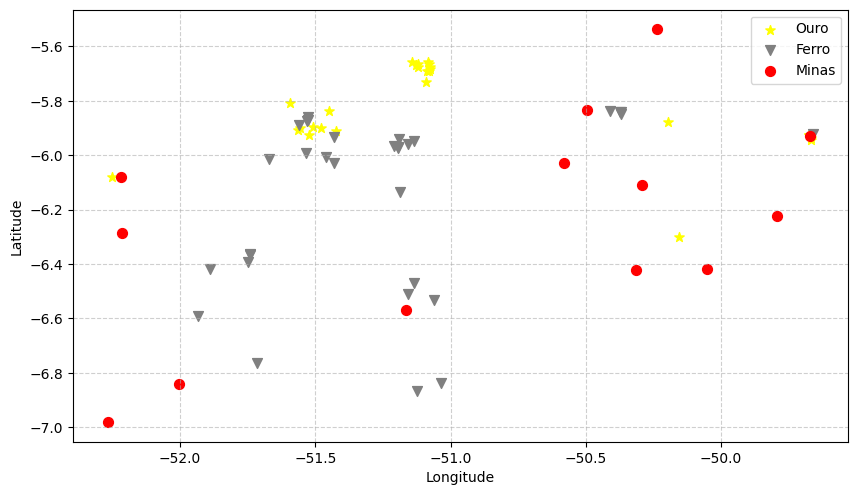

In [5]:
# https://matplotlib.org/stable/api/markers_api.html
fig, ax = plt.subplots(figsize=(10, 10))
ouro.plot(ax=ax, color="yellow", marker="*", markersize=50, label="Ouro")
ferro.plot(ax=ax, color="gray", marker="v", markersize=50, label="Ferro")
minas.plot(ax=ax, color="red", marker="o", markersize=50, label="Minas")
# estruturas.plot(ax=ax, color='blue', alpha=0.5, label='Estruturas')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(visible=True, alpha=0.6, linestyle="--")
plt.legend()
plt.show()

In [6]:
df_ouro = pd.DataFrame(ouro)
df_ouro = df_ouro[["LONGITUDE", "LATITUDE"]]
df_ferro = pd.DataFrame(ferro)
df_ferro = df_ferro[["LONGITUDE", "LATITUDE"]]
for df in [df_ouro, df_ferro]:
    df.rename(columns={"LONGITUDE": "longitude", "LATITUDE": "latitude"}, inplace=True)
    df["longitude"] = df["longitude"].round(3)
    df["latitude"] = df["latitude"].round(3)
    df["ocorrencia"] = 1

df_ouro.head(3)

,longitude,latitude,ocorrencia
0,-51.451,-5.838,1
1,-52.253,-6.078,1
2,-51.558,-5.898,1


- leitura dos dados de espectrometria

  - dados:
    - Fator F: valores altos para rochas alteradas por fluidos que carregam metais
    - Kd: abundância de potássio
    - Ud: abundância de urânio

In [7]:
spec_data = pd.read_csv(
    Path(data_dir, "dados_gamaespectrometria_filtrados.csv"),
    dtype={
        "XUTM": np.float32,
        "YUTM": np.float32,
        "FatorF": np.float32,
        "Kd": np.float32,
        "Ud": np.float32,
    },
)
# spec_data.rename(columns={"XUTM": "X", "YUTM": "Y"}, inplace=True)
spec_data = utm_to_latlon(spec_data, x_col="XUTM", y_col="YUTM")
spec_data.head(3)

,XUTM,YUTM,FatorF,Kd,Ud,longitude,latitude
0,279545.71875,9101977.0,0.001366,-71.005653,-0.349341,-53.001,-8.119
1,279681.28125,9101978.0,0.003305,-28.235151,-0.366232,-52.999,-8.119
2,279816.87500,9101979.0,0.005131,-17.356588,-0.394505,-52.998,-8.119


- leitura dos dados de gravimetria

  - dados:
    - grav_residual190km_qht: Gravity residual at 190km (possibly Bouguer anomaly)
    - grav_residual100km: Gravity residual at 100km
    - maq_asvi: Likely some gravity-related index or processed value
    - maq_qt: Another gravity-related metric, possibly quality or quantity measure

In [8]:
grav_data = pd.read_csv(
    Path(data_dir, "dados_gravmag_filtrados_v2.csv"),
    dtype={
        "X": np.float32,
        "Y": np.float32,
        "grav_residual190km_ght": np.float32,
        "grav_residual100km": np.float32,
        "mag_asvi": np.float32,
        "mag_gt": np.float32,
    },
)
grav_data = utm_to_latlon(grav_data, x_col="X", y_col="Y")
grav_data.head(3)

,X,Y,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,longitude,latitude
0,453679.25,9102751.0,0.000501,-1.943505,67.472176,0.008145,-51.420,-8.117
1,454429.25,9102751.0,0.000573,-1.592606,64.604439,0.008208,-51.414,-8.117
2,455179.25,9102751.0,0.000563,-1.343595,62.171368,0.008150,-51.407,-8.117


- mesclar dfs com dados de gravimetria e espectrometria

In [9]:
df_merge_data = pd.merge(spec_data, grav_data, how="inner", on=["longitude", "latitude"]).drop(
    ["X", "Y", "XUTM", "YUTM"], axis=1
)
df_merge_data = df_merge_data[
    [
        "longitude",
        "latitude",
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
    ]
]
df_merge_data.head(3)

,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt
0,-51.420,-8.117,0.083811,0.012991,0.198352,0.000501,-1.943505,67.472176,0.008145
1,-51.414,-8.117,0.125630,0.402862,0.208304,0.000573,-1.592606,64.604439,0.008208
2,-51.407,-8.117,0.138908,0.430472,0.279669,0.000563,-1.343595,62.171368,0.008150


- criar dataframes base para aprendizado de máquina

In [10]:
df_ouro_merge = criar_dataframe_base(df_merge_data=df_merge_data, df_mineral=df_ouro)
df_ouro_merge.head(3)

,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-53.008,-6.993,0.068392,-0.258163,0.206111,0.000606,9.188570,51.718109,0.010898,0
1,-53.008,-6.980,0.048380,-0.530434,0.224093,0.000336,10.037669,40.085007,0.006150,0
2,-53.008,-6.973,0.016342,-3.743328,0.091279,0.000167,10.274203,35.796360,0.004235,0


In [11]:
df_ferro_merge = criar_dataframe_base(df_merge_data=df_merge_data, df_mineral=df_ferro)
df_ferro_merge.head(3)

,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-53.008,-6.993,0.068392,-0.258163,0.206111,0.000606,9.188570,51.718109,0.010898,0
1,-53.008,-6.980,0.048380,-0.530434,0.224093,0.000336,10.037669,40.085007,0.006150,0
2,-53.008,-6.973,0.016342,-3.743328,0.091279,0.000167,10.274203,35.796360,0.004235,0


In [12]:
print(f"Dados de espectrometria: {spec_data.shape[0]}")
print(f"Dados de gravimetria: {grav_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Mesclagem com ouro (espec + gravim + ouro) : {df_ouro_merge.shape[0]}")
print(f"Mesclagem com ferro (espec + gravim + ferro): {df_ferro_merge.shape[0]}")

Dados de espectrometria: 7672496
Dados de gravimetria: 247298
Mesclagem de dados (espec + gravim): 163283
Mesclagem com ouro (espec + gravim + ouro) : 163308
Mesclagem com ferro (espec + gravim + ferro): 163314


- clusterização de coordenadas geográficas
  - n_clusters = default 8 (tutorial) -> parametrizado

In [13]:
df_ouro_merge = clusterizar_coordenadas_geograficas(df=df_ouro_merge)
df_ferro_merge = clusterizar_coordenadas_geograficas(df=df_ferro_merge)

## aprendizado de máquina

### ouro

#### split treino-teste

- split padrão -> 70% treino e 30% teste

In [16]:
X_train_ouro, X_test_ouro, y_train_ouro, y_test_ouro = split_data(df=df_ouro_merge)

Train shape: (114315, 8), Test shape: (48993, 8)
Class balance - Train: 0.02%, Test: 0.02%


#### pipeline

In [20]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric="logloss"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_ouro = pipeline_ml(models, cv, X_train_ouro, X_test_ouro, y_train_ouro, y_test_ouro)

Tempo total de treino Random Forest: 0.34 min
Random Forest - CV AUC: 1.000 (±0.000)
ROC-AUC: 0.937
F1 Score: 0.933

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48985
           1       1.00      0.88      0.93         8

    accuracy                           1.00     48993
   macro avg       1.00      0.94      0.97     48993
weighted avg       1.00      1.00      1.00     48993

Tempo total de treino Logistic Regression: 0.02 min
Logistic Regression - CV AUC: 0.996 (±0.008)
ROC-AUC: 0.929
F1 Score: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48985
           1       0.00      0.00      0.00         8

    accuracy                           1.00     48993
   macro avg       0.50      0.50      0.50     48993
weighted avg       1.00      1.00      1.00     48993

Tempo total de treino XGBoost: 0.08 min
XGBoost - CV A

- SHAP


Ref: https://shap.readthedocs.io/en/latest/

In [ ]:
# best_model = results_ouro["Random Forest"]['model']

# # Create SHAP explainer
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_test_ouro)

# # Summary plot
# shap.summary_plot(shap_values, X_test_ouro, plot_type="bar")